## Data Mining project: Discover and describe areas of interest an events from geo-located data

## Task #1: Import Dataset and Librarie

## Library Installation

In [128]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
! pip install scipy==1.12.0
# plotting 
! pip install plotly==5.24.1 
! pip install matplotlib==3.8.0 
! pip install seaborn==0.13.2 
! pip install plotly-express==0.4.1 
! pip install chart-studio==1.1.0 
# web app library 
! pip install streamlit==1.37.1 
# association rules
! pip install mlxtend==0.23.3 
! pip install folium==0.19.4
! pip install geopy==2.4.1
! pip install pyproj


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip insta

## Import

In [129]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from geopy.distance import geodesic
from scipy.spatial import ConvexHull, QhullError

from sklearn.cluster import AgglomerativeClustering,  DBSCAN  ,linkage_tree  
from scipy.cluster.hierarchy import dendrogram
import folium
import seaborn as sns


# Data cleaning and preparation

In [130]:
# Charger le fichier CSV
data = pd.read_csv("../data/dataSet.csv", sep=",", low_memory=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   420240 non-null  int64  
 15   date_upload_year

### Type Conversion

In [131]:
# Sélectionner les colonnes 11 et 12 (indices 10 et 11 en pandas)
columns_to_check = data.iloc[:, [11, 12]]

# Parcourir chaque colonne sélectionnée
for col in columns_to_check.columns:
    print(f"Analyse de la colonne: {col}")
    
    # Trouver les types de données présents
    types_present = data[col].map(type).value_counts()
    print("Types présents dans cette colonne :")
    print(types_present)
    
    # Afficher l'utilisation de la mémoire pour cette colonne
    memory_usage = data[col].memory_usage(deep=True)
    print(f"Utilisation de la mémoire pour cette colonne : {memory_usage} bytes\n")

for col in columns_to_check.columns:
    print(f"Conversion de la colonne: {col}")
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)  # Convertir en float, remplacer les erreurs par NaN

    # Vérifier le résultat
    print(f"Colonne {col} après conversion:")
    print(data[col].head())  # Afficher les premières lignes pour valider
    print(f"Types après conversion: {data[col].map(type).value_counts()}\n")

Analyse de la colonne:  date_upload_minute
Types présents dans cette colonne :
 date_upload_minute
<class 'str'>      420228
<class 'float'>        12
Name: count, dtype: int64
Utilisation de la mémoire pour cette colonne : 21366572 bytes

Analyse de la colonne:  date_upload_hour
Types présents dans cette colonne :
 date_upload_hour
<class 'str'>      420238
<class 'float'>         2
Name: count, dtype: int64
Utilisation de la mémoire pour cette colonne : 21349400 bytes

Conversion de la colonne:  date_upload_minute
Colonne  date_upload_minute après conversion:
0    23.0
1    52.0
2    33.0
3    38.0
4    38.0
Name:  date_upload_minute, dtype: float64
Types après conversion:  date_upload_minute
<class 'float'>    420240
Name: count, dtype: int64

Conversion de la colonne:  date_upload_hour
Colonne  date_upload_hour après conversion:
0    20.0
1    17.0
2    17.0
3    12.0
4    12.0
Name:  date_upload_hour, dtype: float64
Types après conversion:  date_upload_hour
<class 'float'>    4202

In [132]:
#rename columms
data.columns = data.columns.str.strip()
print("Colonnes après nettoyage :", data.columns.tolist())

Colonnes après nettoyage : ['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute', 'date_taken_hour', 'date_taken_day', 'date_taken_month', 'date_taken_year', 'date_upload_minute', 'date_upload_hour', 'date_upload_day', 'date_upload_month', 'date_upload_year', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']


### NULL Values

In [133]:
#Find null values
data.isna().sum()

id                         0
user                       0
lat                        0
long                       0
tags                  103510
title                  38329
date_taken_minute          1
date_taken_hour            0
date_taken_day             0
date_taken_month           0
date_taken_year            0
date_upload_minute         0
date_upload_hour           0
date_upload_day            2
date_upload_month          0
date_upload_year           1
Unnamed: 16           420098
Unnamed: 17           420240
Unnamed: 18           420238
dtype: int64

In [134]:
print(f"Initial: {len(data)}")
print(data.columns)
columns_to_clean = [
					'lat', 'long', 'date_taken_minute', 'date_taken_hour', 
					'date_taken_day', 'date_taken_month', 'date_taken_year', 
					'date_upload_minute', 'date_upload_hour', 'date_upload_day', 
					'date_upload_month', 'date_upload_year'
					]
data_cleaned = data.dropna(subset=columns_to_clean)
print(f"After removing missing values: {len(data_cleaned)}")

Initial: 420240
Index(['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute',
       'date_taken_hour', 'date_taken_day', 'date_taken_month',
       'date_taken_year', 'date_upload_minute', 'date_upload_hour',
       'date_upload_day', 'date_upload_month', 'date_upload_year',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')
After removing missing values: 420236


### Duplicates

In [135]:
# Check if there are any duplicates
data_cleaned.duplicated().sum()

252138

In [136]:
# Remove duplicates if necessary
print(f"Initial: {len(data_cleaned)}")
data_cleaned = data_cleaned.drop_duplicates(subset=['user','lat','long','title','date_taken_year','date_taken_month','date_taken_day'],keep='first')
print(f"After removing duplicates: {len(data_cleaned)}") 

Initial: 420236
After removing duplicates: 133922


### Columns

Note that the data with a non-null values at column 16 is sorted differently. We conclude that it is hard to determine which value belongs to which column since date_taken_minute, date_taken_month can be ambigous.

In [137]:
columns = ['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']
column_data = data_cleaned.dropna(subset=columns, how='all')

print(column_data.iloc[0])

id                                                          6674970791
user                                                      29713277@N02
lat                                                          45.753948
long                                                          4.788145
tags                  portrait,throughtheleaves,autraversdesfeuillages
title                                                              NaN
date_taken_minute                                               2012.0
date_taken_hour                                                     29
date_taken_day                                                      12
date_taken_month                                                    10
date_taken_year                                                      9
date_upload_minute                                                 0.0
date_upload_hour                                                  47.0
date_upload_day                                                   21.0
date_u

The rows that have non-null values in columns 16, 17 and 18 are retracted from the dataset. These columns thus serve no purpose and are removed as well.

In [138]:
# Specify the columns to check for non-null values
columns_to_check = ['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']

# Drop rows where any of the specified columns are not null
print(f"Initial: {len(data_cleaned)}")
data_cleaned = data_cleaned[data_cleaned[columns_to_check].isnull().all(axis=1)]
print(f"After removing non-null values: {len(data_cleaned)}")

# Drop the columns
data_cleaned = data_cleaned.drop(columns=columns)

print(data_cleaned.columns)

Initial: 133922
After removing non-null values: 133877
Index(['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute',
       'date_taken_hour', 'date_taken_day', 'date_taken_month',
       'date_taken_year', 'date_upload_minute', 'date_upload_hour',
       'date_upload_day', 'date_upload_month', 'date_upload_year'],
      dtype='object')


### Save Cleaned Data

In [139]:
data_cleaned.to_csv("../data/data-cleaned.csv", index=False)

## Descriptive Statistics

In [140]:
data_cleaned.describe(exclude=[object])

,id,lat,long,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
count,1.338770e+05,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000
mean,1.923862e+10,45.768230,4.837974,29.464792,14.711885,15.154029,7.116689,2013.863442,29.468654,14.537224,15.543200,6.835580,2014.206682
std,1.368314e+10,0.028224,0.029867,17.458652,4.888294,8.741978,3.372268,3.138277,17.215056,6.555018,8.553506,3.478086,2.797429
min,3.066675e+08,45.655200,4.720312,0.000000,0.000000,1.000000,1.000000,1926.000000,0.000000,0.000000,1.000000,1.000000,2009.000000
25%,7.115050e+09,45.757697,4.826163,14.000000,12.000000,8.000000,4.000000,2012.000000,15.000000,11.000000,8.000000,4.000000,2012.000000
50%,1.482560e+10,45.763196,4.832031,30.000000,15.000000,15.000000,7.000000,2014.000000,30.000000,16.000000,15.000000,7.000000,2014.000000
75%,3.021720e+10,45.772754,4.842234,45.000000,18.000000,23.000000,10.000000,2016.000000,44.000000,20.000000,23.000000,10.000000,2017.000000
max,4.914809e+10,45.854950,5.006709,59.000000,23.000000,31.000000,12.000000,2238.000000,59.000000,23.000000,31.000000,12.000000,2019.000000


## Data Visualisation

### Geolocalisation Marker

In [141]:
m = folium.Map(location=(45.764, 4.8357), zoom_start=12)

# Sample a subset of the data (e.g., 500 points)
sampled_data = data_cleaned.sample(n=1000, random_state=1)

latitude_col = sampled_data['lat']
longitude_col = sampled_data['long']

for i in range(0, len(sampled_data)):
	folium.Marker([latitude_col.iloc[i], longitude_col.iloc[i]]).add_to(m)

m

### Geolocalisation Heatmap

In [142]:
from folium.plugins import HeatMap

m = folium.Map(location=(45.764, 4.8357), zoom_start=12)

# Sample a subset of the data (e.g., 500 points)
sampled_data = data_cleaned.sample(n=1000, random_state=1)

latitude_col = sampled_data['lat']
longitude_col = sampled_data['long']

heat_data = [[row['lat'], row['long']] for index, row in sampled_data.iterrows()]
HeatMap(heat_data).add_to(m)

m

## Clustering

### K-Means

The only data necessary to create clusters here would be the latitude and longitude. We'll drop all other columns as it is not necessary.

In [143]:
# Specify the columns to keep
columns = ['lat', 'long']

# Drop all columns except the specified ones
df_clustering = data_cleaned[columns]
print(df_clustering.head())

         lat      long
0  45.754858  4.821710
1  45.753270  4.862953
2  45.760655  4.846564
3  45.784000  4.874072
4  45.784000  4.874072


Although the longitude and latitude have comparable scales, we can use the StandardScaler to normalize the data

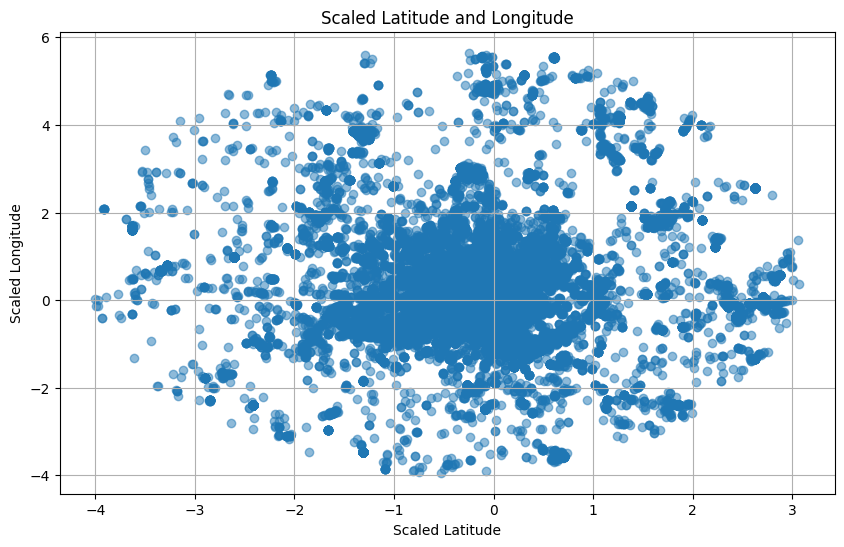

In [144]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)
scaled_data_df = pd.DataFrame(data=scaled_data, columns=df_clustering.columns)

plt.figure(figsize=(10, 6))
plt.scatter(scaled_data_df['lat'], scaled_data_df['long'], alpha=0.5)
plt.title('Scaled Latitude and Longitude')
plt.xlabel('Scaled Latitude')
plt.ylabel('Scaled Longitude')
plt.grid(True)
plt.show()

Interestingly, the same pattern observed in the heatmap is reproduced with the scaled data. This is expected, as the data has been proportionally scaled

We'll find the optimal number of clusters using Elbow method

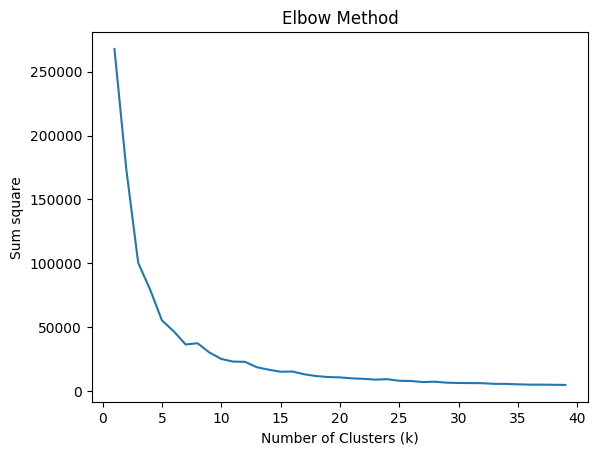

In [145]:
# Range of k values to try
k_values = range(1, 40)
sum_square = []

for k in k_values:
	kmeans = KMeans(n_clusters=k, init='k-means++')
	kmeans.fit(scaled_data_df)
	sum_square.append(kmeans.inertia_)

plt.plot(k_values, sum_square)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum square')
plt.show()


The optimal number of clusters can be interpreted to be between 6-10. We found that with 6-10 clusters, the granularity of places is not as well defined as the number of points are extremely vast and spreaded.

In [146]:
kmeans = KMeans(n_clusters=70, init='k-means++')
kmeans.fit(scaled_data_df)
data_cleaned['cluster_kmeans'] = kmeans.labels_ 
print(data_cleaned[['cluster_kmeans', 'lat', 'long']])

        cluster_kmeans        lat      long
0                   61  45.754858  4.821710
1                   57  45.753270  4.862953
2                   62  45.760655  4.846564
3                   22  45.784000  4.874072
4                   22  45.784000  4.874072
...                ...        ...       ...
413846              22  45.781863  4.875416
419007              32  45.729498  4.951550
419071              41  45.768700  4.840502
419137              18  45.771852  4.833115
420066               6  45.762044  4.821358

[133877 rows x 3 columns]


In [147]:
# Center map
m = folium.Map(location=[data_cleaned['lat'].mean(), data_cleaned['long'].mean()], zoom_start=12)

palette = sns.color_palette("hsv", n_colors=data_cleaned['cluster_kmeans'].nunique())
colors = [mcolors.rgb2hex(color) for color in palette]

centroids = scaler.inverse_transform(kmeans.cluster_centers_)
sampled_data = data_cleaned.sample(n=20000, random_state=1)
cluster_counts = sampled_data['cluster_kmeans'].value_counts()

valid_clusters = cluster_counts[cluster_counts >= 3].index.tolist()

filtered_sampled_data = sampled_data[sampled_data['cluster_kmeans'].isin(valid_clusters)]
cluster_id_sample = filtered_sampled_data['cluster_kmeans'].unique().tolist()

print(cluster_id_sample) 

# Filter points based on distance to centroids
filtered_points = filtered_sampled_data[filtered_sampled_data.apply(
    lambda row: any(geodesic((row['lat'], row['long']), centroid).m <= 300 for centroid in centroids), axis=1)]

# Map markers
for i, row in filtered_points.iterrows():
    point = (row['lat'], row['long'])
    folium.CircleMarker(
        location=point,
        radius=1,
        color=colors[row['cluster_kmeans']],
        fill=True,
        fill_color=colors[row['cluster_kmeans']]
    ).add_to(m)

# Centroids and hulls
for cluster_id in cluster_id_sample:
    cluster_points = filtered_points[filtered_points['cluster_kmeans'] == cluster_id][['lat', 'long']].values
    if len(cluster_points) >= 3:  # ConvexHull requires at least 3 points
        try: 
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Skipping cluster {cluster_id} due to QhullError")
    centroid = centroids[cluster_id]
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Centroid {cluster_id}',
    ).add_to(m)

m.save("../html/kmeans_map.html")

[32, 61, 62, 1, 6, 29, 3, 4, 38, 15, 41, 46, 49, 47, 42, 12, 39, 33, 44, 0, 18, 14, 69, 23, 26, 45, 56, 36, 10, 40, 34, 25, 17, 22, 58, 8, 16, 65, 11, 31, 9, 63, 7, 55, 21, 52, 5, 35, 64, 24, 20, 68, 48, 37, 66, 43, 54, 57, 28, 13, 67, 27, 30, 53, 50, 59, 2, 19, 60, 51]
Skipping cluster 26 due to QhullError
Skipping cluster 10 due to QhullError
Skipping cluster 34 due to QhullError
Skipping cluster 17 due to QhullError
Skipping cluster 5 due to QhullError
Skipping cluster 51 due to QhullError


### H-Clust

Initial: 133877
After removing duplicates: 66804


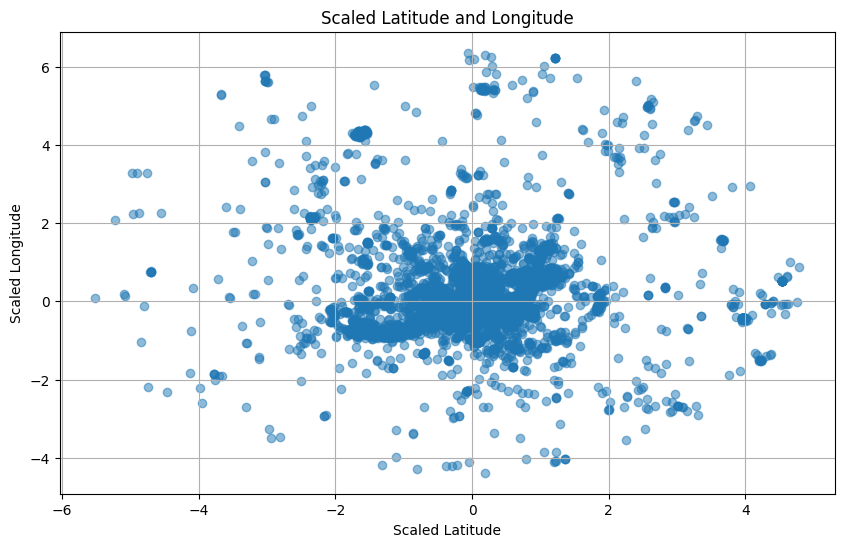

In [148]:
df_clustering_without_duplicates = df_clustering.drop_duplicates() # Drop duplicates
print(f"Initial: {len(df_clustering)}")
print(f"After removing duplicates: {len(df_clustering_without_duplicates)}")
df_clustering_without_duplicates = df_clustering_without_duplicates.sample(n=10000, random_state=1) # Sample a subset of the data
scaler = StandardScaler()
scaled_data_duplicates = scaler.fit_transform(df_clustering_without_duplicates)
scaled_data_duplicates_df = pd.DataFrame(data=scaled_data_duplicates, columns=df_clustering.columns)

plt.figure(figsize=(10, 6))
plt.scatter(scaled_data_duplicates_df['lat'], scaled_data_duplicates_df['long'], alpha=0.5)
plt.title('Scaled Latitude and Longitude')
plt.xlabel('Scaled Latitude')
plt.ylabel('Scaled Longitude')
plt.grid(True)
plt.show()


In [149]:
# Vérifier que 'lat' et 'long' sont bien présentes dans le DataFrame
if 'lat' not in df_clustering_without_duplicates.columns or 'long' not in df_clustering_without_duplicates.columns:
    raise ValueError("Les colonnes 'lat' et 'long' doivent être présentes dans le DataFrame.")

# Si 'hierarchical_cluster' n'existe pas, on applique le clustering
if 'hierarchical_cluster' not in df_clustering_without_duplicates.columns:
    hierarchical_cluster = AgglomerativeClustering(n_clusters=20)  # Ajustez le nombre de clusters
    df_clustering_without_duplicates['hierarchical_cluster'] = hierarchical_cluster.fit_predict(df_clustering_without_duplicates[['lat', 'long']])

# Palette de couleurs
palette = sns.color_palette("hsv", n_colors=df_clustering_without_duplicates['hierarchical_cluster'].nunique())
colors = [mcolors.rgb2hex(color) for color in palette]

# Calculer les centroids manuellement pour chaque cluster
centroids = df_clustering_without_duplicates.groupby('hierarchical_cluster')[['lat', 'long']].mean().values

# Centrer la carte
m = folium.Map(location=[df_clustering_without_duplicates['lat'].mean(), df_clustering_without_duplicates['long'].mean()], zoom_start=12)

# Filtrer les points basés sur la distance aux centroids
filtered_points = df_clustering_without_duplicates[df_clustering_without_duplicates.apply(
    lambda row: any(geodesic((row['lat'], row['long']), centroid).m <= 200 for centroid in centroids), axis=1)]

# Ajouter des points filtrés à la carte
for i, row in filtered_points.iterrows():
    point = (row['lat'], row['long'])
    cluster_id = int(row['hierarchical_cluster'])  # Convertir en entier
    folium.CircleMarker(
        location=point,
        radius=1,
        color=colors[cluster_id],  # Utiliser 'hierarchical_cluster' pour la couleur
        fill=True,
        fill_color=colors[cluster_id]
    ).add_to(m)

# Dessiner les Convex Hulls et les centroids
for cluster_id in range(df_clustering_without_duplicates['hierarchical_cluster'].nunique()):
    cluster_points = filtered_points[filtered_points['hierarchical_cluster'] == cluster_id][['lat', 'long']].values
    if len(cluster_points) >= 3:  # ConvexHull nécessite au moins 3 points
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except Exception as e:
            print(f"Erreur avec le cluster {cluster_id}: {e}")

    centroid = centroids[cluster_id]
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Centroid {cluster_id}',
    ).add_to(m)

# Sauvegarder la carte
m.save("../html/hierarchical.html")


## DBSCAN

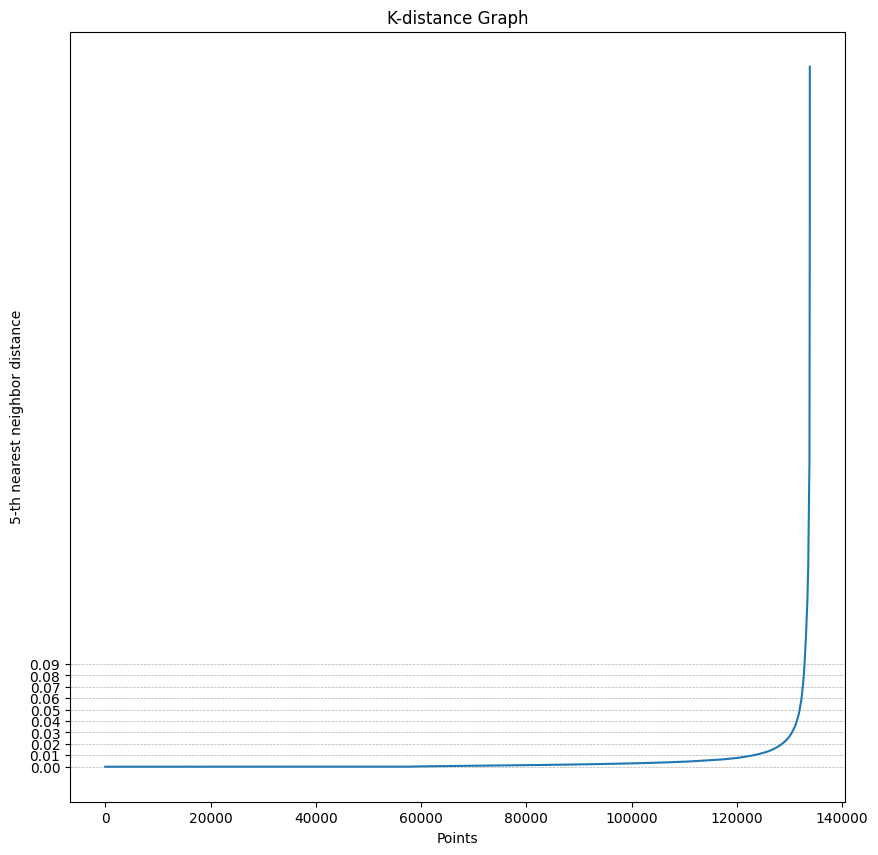

In [150]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 10))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')

    y_min, y_max = 0, 0.1
    y_ticks = np.arange(y_min, y_max, 0.01)  # Création des ticks de 0.001 en 0.001
    plt.yticks(y_ticks)
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(scaled_data_df, k=5)

In [151]:


dbscan = DBSCAN(eps=0.0058, min_samples=56)  

dbscan.fit(scaled_data_df)
data_cleaned['cluster_dbscan'] = dbscan.labels_
print(data_cleaned['cluster_dbscan'].value_counts())

cluster_dbscan
-1      61901
 3      11370
 0       6157
 1       5462
 2       4431
        ...  
 194       56
 184       47
 196       46
 166       44
 168       26
Name: count, Length: 209, dtype: int64


In [152]:


# Créer une carte centrée sur la moyenne des coordonnées
m = folium.Map(location=[data_cleaned['lat'].mean(), data_cleaned['long'].mean()], zoom_start=12)

# Filtrer les clusters valides (exclure le bruit: cluster -1)
valid_clusters = data_cleaned['cluster_dbscan'][data_cleaned['cluster_dbscan'] != -1].unique()
palette = sns.color_palette("hsv", n_colors=len(valid_clusters))
colors = {cluster: mcolors.rgb2hex(color) for cluster, color in zip(valid_clusters, palette)}

# Sous-échantillonnage
sampled_data = data_cleaned.sample(n=min(20000, len(data_cleaned)), random_state=1)

# Ajouter les points de clusters à la carte
for i, row in sampled_data.iterrows():
    cluster_id = row['cluster_dbscan']
    if cluster_id == -1:  # Ignorer le bruit
        continue
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=1,
        color=colors[cluster_id],
        fill=True,
        fill_color=colors[cluster_id]
    ).add_to(m)

# Calculer les barycentres des clusters pour les représenter comme "centroïdes"
for cluster_id in valid_clusters:
    cluster_points = data_cleaned[data_cleaned['cluster_dbscan'] == cluster_id][['lat', 'long']].values
    
    if len(cluster_points) == 0:
        continue
    
    # Barycentre du cluster
    centroid = cluster_points.mean(axis=0)
    
    # Ajouter un marqueur pour le barycentre
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Cluster {cluster_id}',
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    # Dessiner l'enveloppe convexe si au moins 3 points
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Skipping cluster {cluster_id} due to QhullError")

# Sauvegarder la carte
m.save("../html/dbscan_map.html")

Skipping cluster 5 due to QhullError
Skipping cluster 39 due to QhullError
Skipping cluster 51 due to QhullError
Skipping cluster 55 due to QhullError
Skipping cluster 57 due to QhullError
Skipping cluster 59 due to QhullError
Skipping cluster 75 due to QhullError
Skipping cluster 84 due to QhullError
Skipping cluster 91 due to QhullError
Skipping cluster 98 due to QhullError
Skipping cluster 100 due to QhullError
Skipping cluster 103 due to QhullError
Skipping cluster 107 due to QhullError
Skipping cluster 117 due to QhullError
Skipping cluster 120 due to QhullError
Skipping cluster 123 due to QhullError
Skipping cluster 126 due to QhullError
Skipping cluster 127 due to QhullError
Skipping cluster 130 due to QhullError
Skipping cluster 136 due to QhullError
Skipping cluster 143 due to QhullError
Skipping cluster 144 due to QhullError
Skipping cluster 148 due to QhullError
Skipping cluster 154 due to QhullError
Skipping cluster 158 due to QhullError
Skipping cluster 162 due to QhullErr

In [153]:

from pyproj import Proj, Transformer

dbscan = DBSCAN(eps=0.02, min_samples=4)  
dbscan.fit(scaled_data_df)
data_cleaned['cluster_dbscan'] = dbscan.labels_



# Définir la projection UTM pour la zone (ex: Lyon = UTM zone 31T)
proj = Proj(proj="utm", zone=31, ellps="WGS84", datum="WGS84")
transformer = Transformer.from_proj(Proj("epsg:4326"), proj)

# Appliquer la transformation
scaled_data_df['x'], scaled_data_df['y'] = transformer.transform(df_clustering['lat'], df_clustering['long'])


# Afficher le résultat


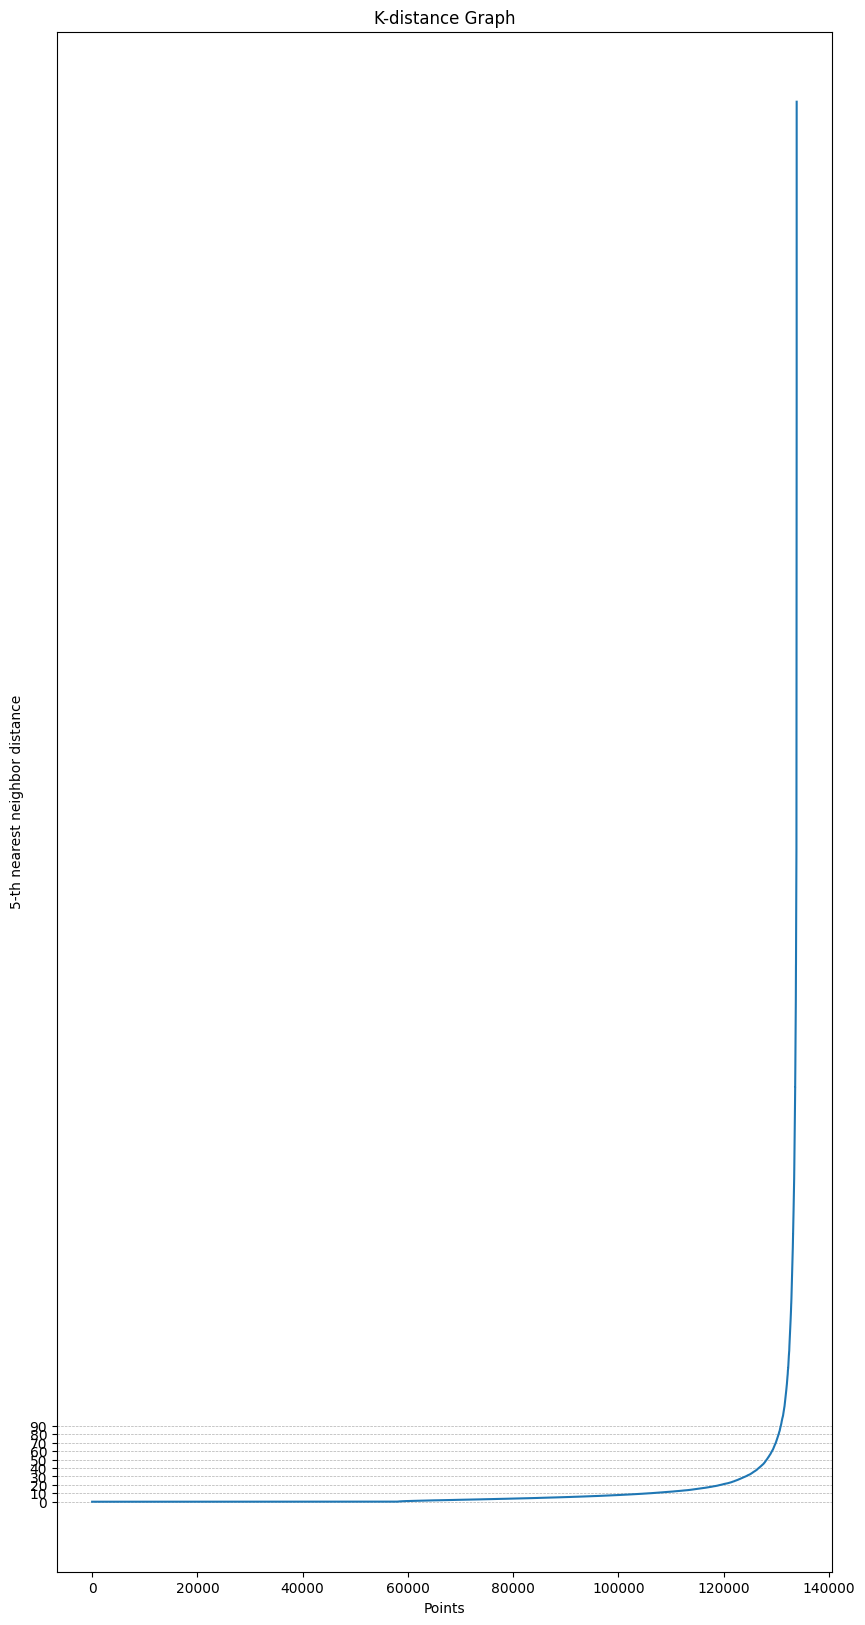

In [154]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 20))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')

    y_min, y_max = 0, 100
    y_ticks = np.arange(y_min, y_max, 10)  # Création des ticks de 0.001 en 0.001
    plt.yticks(y_ticks)
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(scaled_data_df, k=5)